# Geotiff Interpolation Tutorial

The purpose of this notebook is to demonstrate interpolation from geotiff files to lon/lat pairs. In this case, the geotiff files are bands from HRRR grib2 files collected using `wrfxpy` methods on Alderaan. The lon/lat pairs are collected from RAWS stations with `Mesopy`, and assumed to be in the WGS84 standard coordinate system AKA EPSG 4326.

The tiff files are saved with naming a convention that stores the UTC time info as well as the associated band. See:

https://www.nco.ncep.noaa.gov/pmb/products/hrrr/hrrr.t00z.wrfprsf00.grib2.shtml

# Setup 

In [1]:
import os
import os.path as osp
import numpy as np
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path = os.getcwd()
tpath = osp.join(path,"hrrr.t14z.wrfprsf00.585.tif")

In [3]:
# Get RAWS Station lat/lon
sts = pd.read_csv("C:/Users/jhirs/Documents/Projects/openwfm/notebooks/fmda/data/raws_stations_CO.csv")
sts

,STID,air_temp,relative_humidity,precip_accum,fuel_moisture,wind_speed,solar_radiation,lon,lat
0,KAFF,1,1,0,0,1,0,-104.81667,38.96667
1,KAKO,1,1,0,0,1,0,-103.21459,40.17428
2,KALS,1,1,0,0,1,0,-105.86180,37.43933
3,KAPA,1,1,0,0,1,0,-104.84841,39.55991
4,KASE,1,1,0,0,1,0,-106.87051,39.22992
...,...,...,...,...,...,...,...,...,...
1212,G1361,1,1,0,0,1,1,-105.10750,39.69883
1213,G1378,1,1,0,0,1,0,-105.42250,39.48917
1214,G1550,1,1,0,0,1,1,-105.01517,38.45217
1215,G1725,1,1,0,0,1,1,-105.05217,40.56150


## Read Raster File

In [4]:
# Extract data from tif file
ds = gdal.Open(tpath)
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
gp = ds.GetProjection()

In [5]:
print(width)
print(height)
print(gt)
print(gp)

1799
1059
(-2699020.142521929, 3000.0, 0.0, 1588193.847443335, 0.0, -3000.0)
PROJCS["unnamed",GEOGCS["Coordinate System imported from GRIB file",DATUM["unnamed",SPHEROID["Sphere",6371229,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",38.5],PARAMETER["central_meridian",-97.5],PARAMETER["standard_parallel_1",38.5],PARAMETER["standard_parallel_2",38.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [6]:
print('Raster count: ' + str(ds.RasterCount))

Raster count: 1


In [7]:
band = ds.GetRasterBand(1)
data = band.ReadAsArray()

# Plot Raster File

Using `imshow`, add a point at 100,100 just to demonstrate image indexing.

source: https://www.geeksforgeeks.org/visualizing-tiff-file-using-matplotlib-and-gdal-using-python/

Text(100, 100, '(100,100)')

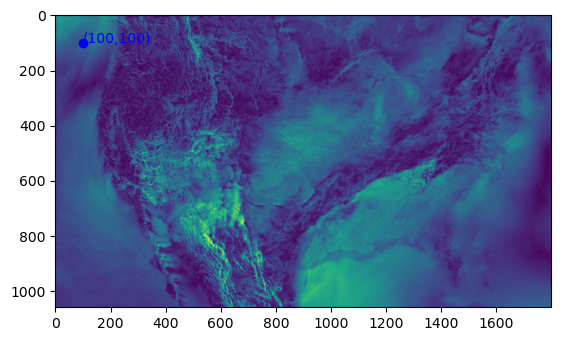

In [8]:
# Plot
plt.imshow(data)
plt.plot(100, 100, marker='o', color='blue', markersize=6)
plt.annotate("(100,100)", (100,100), color='blue')

# Nearest Neighbor Lat/Lon

Source (nearest neighbor method): https://stackoverflow.com/questions/69034965/given-a-geotiff-file-how-does-one-find-the-single-pixel-closest-to-a-given-lati

In [9]:
point_srs = osr.SpatialReference()
point_srs.ImportFromEPSG(4326) # hardcode for lon/lat

# GDAL>=3: make sure it's x/y
# see https://trac.osgeo.org/gdal/wiki/rfc73_proj6_wkt2_srsbarn
point_srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)     

file_srs = osr.SpatialReference()
file_srs.ImportFromWkt(gp)

0

In [10]:
ct = osr.CoordinateTransformation(point_srs, file_srs)

point_x = sts['lon'][0] # lon
point_y = sts['lat'][0]  # lat
mapx, mapy, z = ct.TransformPoint(point_x, point_y) # output: coordinate pair (m)

In [11]:
gt_inv = gdal.InvGeoTransform(gt)
pixel_x, pixel_y = gdal.ApplyGeoTransform(gt_inv, mapx, mapy)

We plot the image with the pixel annotated. The lon/lat pair is from a RAWS station near Colorado Springs, which matches the image below.

Text(589.025656424631, 453.722879875854, 'Lon/Lat: (-104.82, 38.97)')

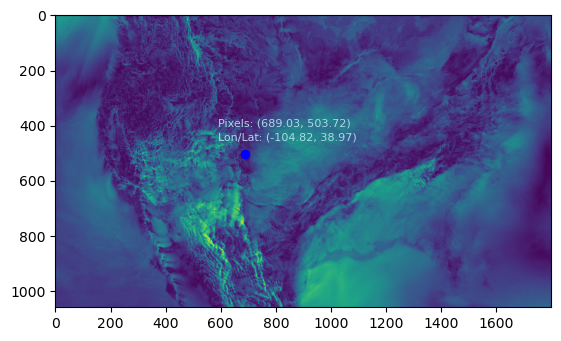

In [12]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6)
plt.annotate(f"Pixels: ({round(pixel_x, 2)}, {round(pixel_y, 2)})", xy=(pixel_x, pixel_y),
            xytext=(pixel_x-100, pixel_y-100), fontsize=8, color='lightblue')
plt.annotate(f"Lon/Lat: ({round(point_x, 2)}, {round(point_y, 2)})", xy=(pixel_x, pixel_y),
           xytext=(pixel_x-100, pixel_y-50), fontsize=8, color='lightblue')

After this point, the tutorial goes on to describe a method for nearest neighbor. This is just one form of interpolation, so various methods will be explored below.

We will plot a zoomed in version of the pixels to demonstrate this.

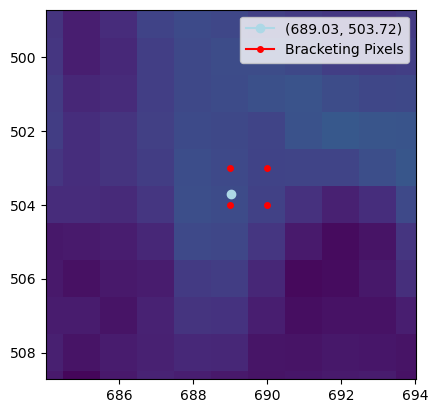

In [13]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='lightblue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=np.floor(pixel_x), np.floor(pixel_y)
x2, y2=np.floor(pixel_x), np.ceil(pixel_y)
x3, y3=np.ceil(pixel_x), np.floor(pixel_y)
x4, y4=np.ceil(pixel_x), np.ceil(pixel_y)

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

plt.legend()

# Interpolation Methods

## Nearest Neighbor

The tutorial linked above simply rounds the pixel x and y coordinates to the nearest pixels and takes the value from that grid location. This is mathematically equivalent to an L1 nearest neighbor, or manhattan distance minimization.

In [14]:
# round to pixel
x_l1 = round(pixel_x)
y_l1 = round(pixel_y)

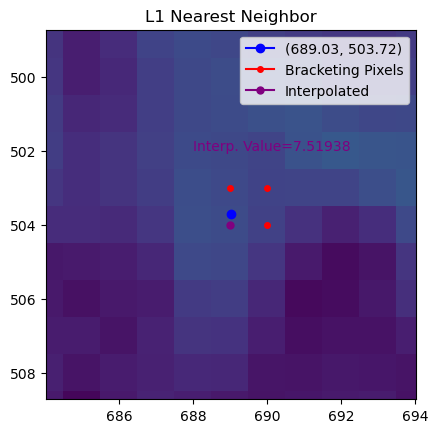

In [15]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=np.floor(pixel_x), np.floor(pixel_y)
x2, y2=np.floor(pixel_x), np.ceil(pixel_y)
x3, y3=np.ceil(pixel_x), np.floor(pixel_y)
x4, y4=np.ceil(pixel_x), np.ceil(pixel_y)

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

# Plot interpolated pixel
plt.plot(x_l1,y_l1, marker='o', color='purple', markersize=5,
        label='Interpolated')
interp_val = data[y_l1, x_l1] # NOTE: xy flip is build in GDAL
plt.annotate("Interp. Value="+str(round(interp_val, 5)), xy=(x_l1, y_l1), xytext=(x_l1-1, y_l1-2), color='purple')

plt.title("L1 Nearest Neighbor")
plt.legend()

NOTE: The HRRR documentation says that 2m Temperature, band 616, should be in degrees K. But obviously this data is in degrees C. We will have to check this in the future.

## Nearest Neighbor (Euclidean)

In `wrfxpy`, the function `find_closest_grid_point` is defined to find the L2 nearest neighbor, which finds the minimum sum of squared distance (Euclidean norm).

https://github.com/openwfm/wrfxpy/blob/master/src/utils.py#L529

NOTE: very slow implementation, but I wanted to reproduce the method clearly. In this case, the interpolated value is the same as L1.

In [16]:
x = np.arange(0, band.XSize)
y = np.arange(0, band.YSize)
pixels = [(xx, yy) for xx in x for yy in y]
d = np.zeros(len(pixels))
for i in range(0, len(pixels)):
    p = pixels[i]
    d[i] = (pixel_x - p[0])**2 + (pixel_y - p[1])**2

nearest = pixels[np.argmin(d)]

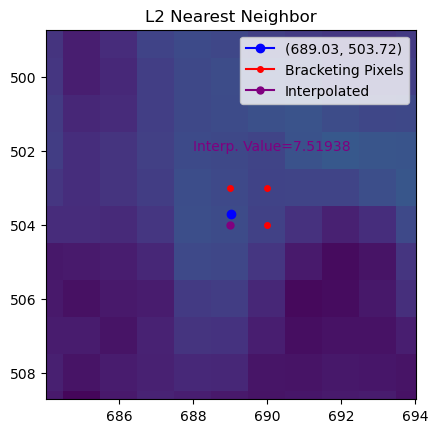

In [17]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=np.floor(pixel_x), np.floor(pixel_y)
x2, y2=np.floor(pixel_x), np.ceil(pixel_y)
x3, y3=np.ceil(pixel_x), np.floor(pixel_y)
x4, y4=np.ceil(pixel_x), np.ceil(pixel_y)

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

# find nearest L2 pixel
plt.plot(nearest[0],nearest[1], marker='o', color='purple', markersize=5,
        label='Interpolated')
interp_val = data[nearest[1], nearest[0]]
plt.annotate("Interp. Value="+str(round(interp_val, 5)), xy=(x_l1, y_l1), xytext=(x_l1-1, y_l1-2), color='purple')


plt.title("L2 Nearest Neighbor")
plt.legend()

## Average Bracketing Points

Given the 4 bracketing points, interpolate the mean value.

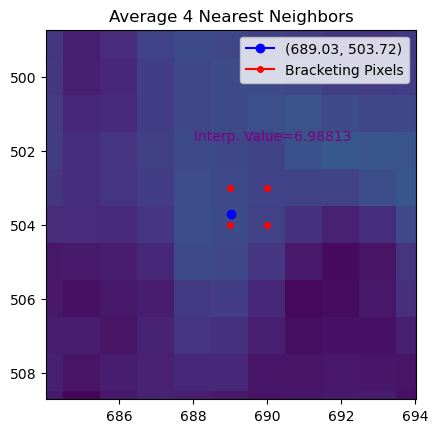

In [18]:
plt.imshow(data)

# Plot pixel translation with annotations
plt.plot(pixel_x,pixel_y, marker='o', color='blue', markersize=6,
        label=f"({round(pixel_x, 2)}, {round(pixel_y, 2)})")

# Zoom in, set limits from plotted pixel
offset = 5
plt.xlim(pixel_x-offset, pixel_x+offset) # Note different +/- bc origin is topright
plt.ylim(pixel_y+offset,pixel_y-offset)

# Plot 4 points bracketing target pixel
x1, y1=int(np.floor(pixel_x)), int(np.floor(pixel_y))
x2, y2=int(np.floor(pixel_x)), int(np.ceil(pixel_y))
x3, y3=int(np.ceil(pixel_x)), int(np.floor(pixel_y))
x4, y4=int(np.ceil(pixel_x)), int(np.ceil(pixel_y))

plt.plot(x1,y1, marker='o', color='red', markersize=4, label='Bracketing Pixels')
plt.plot(x2,y2, marker='o', color='red', markersize=4)
plt.plot(x3,y3, marker='o', color='red', markersize=4)
plt.plot(x4,y4, marker='o', color='red', markersize=4)

interp_val = np.mean([data[y1, x1], data[y2, x2], data[y3, x3], data[y4, 4]])
plt.annotate("Interp. Value="+str(round(interp_val, 5)), xy=(pixel_x, pixel_y), xytext=(pixel_x-1, pixel_y-2), color='purple')


plt.title("Average 4 Nearest Neighbors")
plt.legend()

## Scipy RegularGrid interpolation package

Working on the regular grid of pixel values, we can use the `RegularGridInterpolator` function from `scipy`.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html

https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html

In [19]:
from scipy.interpolate import griddata, RegularGridInterpolator
# regular grid of points
# point_x = sts['lon'][0] # lon
# point_y = sts['lat'][0]  # lat
pt_grid = [np.arange(0, data.shape[0]), np.arange(0, data.shape[1])]
interp = RegularGridInterpolator(pt_grid, data)
interp_pts = np.array([pixel_y, pixel_x])

# point_x = sts['lon'][0] # lon
# point_y = sts['lat'][0]  # lat

In [20]:
interp(interp_pts, method="linear")

array([7.44006413])

As a check, the "nearest" method should return what we did previously:

In [21]:
interp = RegularGridInterpolator(pt_grid, data, method="nearest")
interp(interp_pts, method="nearest")

array([7.51938057])

## Adapting WRF-Fire Method

The WRF-Fire interpolation method combines a nearest neighbors approach and a linear interpolation. The steps are:
* Find nearest neighbor
* Construct 3x3 array centered at nearest neighbor
* Run linear interpolation (matlab's `scatteredInterpolant` method)

The python equivalent of `scatteredInterpolant` is `scipy.interpolate.griddata` (according to StackOverflow and ChatGPT). But with the current data flow, the spatial data comes in on a regular grid plus projection info to transform that regular grid onto the surface of the Earth. So we will use `scipy.interpolate.RegularGridInterpolator`

WRF-Fire Sources:

https://github.com/openwfm/wrf-fire-matlab/blob/master/vis/ts_at.m

https://github.com/openwfm/wrf-fire-matlab/blob/master/vis/ts_at_test.

First, we will use `RegularGridInteprolator` with the subgrid of 9 pixels.


In [22]:
def ts_at(interp_x, interp_y, values, method = "linear"):

    interp_pts = np.array([interp_y, interp_x])
    
    # Get nearest neighbor
    center_x = round(interp_x)
    center_y = round(interp_y)
    
    # Build 3x3 grid around center, NOTE: xy flip in GDAL
    grid = np.meshgrid(np.array([center_y-1, center_y, center_y+1]),
            np.array([center_x-1, center_x, center_x+1]))
    grid = np.array([grid[0].flatten(), grid[1].flatten()]).T
    # Subset values
    value9 = values[
        grid[:,0], 
        grid[:,1]]
    value9=value9.reshape(3,3)
    
    interp = RegularGridInterpolator([np.array([center_y-1, center_y, center_y+1]),np.array([center_x-1, center_x, center_x+1])], value9)
    
    return interp(interp_pts, method=method)

In [23]:
ts_at(pixel_x, pixel_y, data)

array([7.61074282])

## Validate Linear Interpolation

Goals:
* Define some linear function and generate values on a regular grid.
* Interpolate with method above and compare to known values
* Check that error is small

In [24]:
# Use grid of points to generate values
X, Y = np.meshgrid(np.arange(0, data.shape[1]), np.arange(0, data.shape[0]))
values = np.zeros(data.shape)

# Define v as a linear function a*x+b*y
a = 2
b = 3
for i in range(0, height):
    for j in range(0, width):
        values[i,j] = a*X[i,j] + b*Y[i,j]

In [25]:
# Hand check last value calc...
print(f"Values[{height}, {width}] = {values[-1, -1]}")
print(a*(width-1)+b*(height-1))

# Check point (100, 200), NOTE order of values flipped in gdal
print(f"Values[100,200] = {values[100, 200]}")
print(a*(200)+b*(100))

Values[1059, 1799] = 6770.0
6770
Values[100,200] = 700.0
700


In [26]:
# Test ts_at function for a few points...
np.random.seed(123)
for i in range(0, 5):
    print('~'*25)
    xi = np.random.randint(0, width)
    yi = np.random.randint(0, height)
    print(f"Sampled Point: {xi, yi}, Value: {values[yi, xi]}")
    vi = ts_at(xi, yi, values, "linear")
    print(f"Interpolated Point: {vi}")

~~~~~~~~~~~~~~~~~~~~~~~~~
Sampled Point: (1534, 1041), Value: 6191.0
Interpolated Point: [6191.]
~~~~~~~~~~~~~~~~~~~~~~~~~
Sampled Point: (1619, 106), Value: 3556.0
Interpolated Point: [3556.]
~~~~~~~~~~~~~~~~~~~~~~~~~
Sampled Point: (1147, 96), Value: 2582.0
Interpolated Point: [2582.]
~~~~~~~~~~~~~~~~~~~~~~~~~
Sampled Point: (113, 638), Value: 2140.0
Interpolated Point: [2140.]
~~~~~~~~~~~~~~~~~~~~~~~~~
Sampled Point: (47, 73), Value: 313.0
Interpolated Point: [313.]


## Validate Nearest Neighbors Geolocation

Goals:

* create two fake geotiff
* create data array with known lon/lat values
* evaluate and you should get coord back exactly

Steps here:

* Convert pixel indices (e.g. (0,0), (0,1)...) to lat lon
* Save lats and lons in array of same dimension as raster band
* Save as geotiff
* Read that file back in to do steps above


Modified from Source: https://stackoverflow.com/questions/59052516/find-lat-long-coordinates-from-pixel-point-in-geotiff-using-python-and-gdaltly

In [27]:
# Generate Arrays of pixel indices
lons = np.zeros((1059, 1799))
lats = np.zeros((1059, 1799))

In [28]:
from osgeo import osr, ogr, gdal

def pixel_to_world(geo_matrix, x, y):
    # Given geotransform info of a geotiff file and an (x,y) pixel coord pair, return the coord pair that matches the geotiff in meters
    # Inputs: 
    # geomatrix: output of ds.GetGeoTransform() for given geotiff file
    # tuple of length 6 contains: 
    # A geotransform consists in a set of 6 coefficients
    # GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
    # GT(1) w-e pixel resolution / pixel width.
    # GT(2) row rotation (typically zero).
    # GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
    # GT(4) column rotation (typically zero).
    # GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
    # x: pixel index x coord (1)
    # y: pixel index y coord (1)
    # Return: coordinates of same point as given x,y as offset from UL (m)
    # Example: pixel_to_world(mat, 0, 0) returns UL x,y from geotiff
    
    ul_x = geo_matrix[0]
    ul_y = geo_matrix[3]
    x_dist = geo_matrix[1]
    y_dist = geo_matrix[5]
    _x = x * x_dist + ul_x
    _y = y * y_dist + ul_y
    return _x, _y


def build_transform_inverse(dataset, EPSG):
    # Given gdal dataset and target EPSG, return transformation function that transforms meter coord pairs to pixel coord pairs 
    # Inputs:
    # dataset: geotiff file
    # EPSG: integer
    source = osr.SpatialReference(wkt=dataset.GetProjection())
    target = osr.SpatialReference()
    target.ImportFromEPSG(EPSG)
    return osr.CoordinateTransformation(source, target)

def world_to_epsg(wx, wy, trans):
    # Inputs:
    # wx, wy: output of build_transform_inverse
    # wx: x coordinate (m) related to geotiff reference point
    # wy: y coordinate (m) related to geotiff reference point
    # transform: function to transform to given epsg, function type is osgeo.osr.CoordinateTransformation
    # Return: 
    # point from osgeo Geometry object
    point = ogr.Geometry(ogr.wkbPoint)
    point.AddPoint(wx, wy)
    point.Transform(trans)
    return point

def find_spatial_coordinate_from_pixel(dataset, x, y, transform=None, epsg=4326):
    # Given gdal dataset, target x y pixel pair, and EPSG, return the EPSG defined coordinate pair 
    # dataset: gdal dataset, from geotiff file
    # x (int): pixel x index 
    # y (int): pixel y index 
    ## Upper left corner is often (0,0)
    # transform: transform inverse. output of build_transform_inverse, default none and it calculates from epsg
    # supply transform to save computational time
    # epsg: default 4326 (WGS84)
    # Return: coord pair in given epsg, eg lat/lon (floats)
    if transform is None:
        transform = build_transform_inverse(ds, epsg)
    world_x, world_y = pixel_to_world(dataset.GetGeoTransform(), x, y)
    point = world_to_epsg(world_x, world_y, transform)
    return point.GetX(), point.GetY()

ds = gdal.Open(tpath)

We want this process to match information from the gdalinfo in the geotiff file. The command line `gdalinfo hrrr.t00z.wrfprsf00.616.tif` returns info on the corner coordinates and center (not (0,0) for some reason). The following output should thus match the return of that command.

`gdalinfo` returns coordinates in the "degrees minute second" format, so we need to convert decimal degrees to this format to make sure it matches. 


In [29]:
## Test world_to_epsg
## For 'center' in file (-520.143, -306.153), not zero for some reason
## Should return ( 97d30'21.52"W, 38d29'50.09"N)
trans = build_transform_inverse(ds, 4326)
pt = world_to_epsg(-520.143, -306.153, trans)
print(f"({pt.GetX()},{pt.GetY()})")

(38.49724664701337,-97.50597669653496)


In [30]:
## Test on a corner coords
print(find_spatial_coordinate_from_pixel(ds, 0, 0)) # upper left
print(find_spatial_coordinate_from_pixel(ds, 0, 1058)) # upper right
print(find_spatial_coordinate_from_pixel(ds, 1798, 0)) # lower left
print(find_spatial_coordinate_from_pixel(ds, 1798, 1058)) # lower right

(47.84573454341426, -134.12142793280145)
(21.14706163554821, -122.73660944167882)
(47.8596079443964, -60.92779791187434)
(21.15647650951475, -72.29930710271951)


`gdalinfo` returns coordinates with the format "degree minute second(direction)", so we convert the values from `gdalinfo` to check...

Source: stackexchange ___

In [31]:
def decdeg2dms(dd, nsec=4):
    # Given decimal degree, turn Degree Minute Second format
    # dd: decimal lat/lon coord
     # nsec: number of digits to round second
    mult = -1 if dd < 0 else 1
    mnt,sec = divmod(abs(dd)*3600, 60)
    deg,mnt = divmod(mnt, 60)
    deg=mult*deg
    mnt=mult*mnt
    sec=np.round(mult*sec, nsec)
    
    date_str = f"{deg}d {mnt}'{sec}"
    return date_str

Check on coordinates listed in `gdalinfo`

Using coords in meters, convert first with `world_to_epsg` then evaluate with `decdeg2dms`. Note: negative coordinates correspond to degrees West or degrees South from point of origin (in HRRR files the origin is in continental US).

In [32]:
# Print lon/lat coords
ul = world_to_epsg(-2699020.143, 1588193.847, trans) # Upper left
print(f"({ul.GetX()},{ul.GetY()})")
ll = world_to_epsg(-2699020.143,-1588806.153, trans) # Lower left
print(f"({ll.GetX()},{ll.GetY()})")
ur = world_to_epsg(2697979.857, 1588193.847, trans) # Upper right
print(f"({ur.GetX()},{ur.GetY()})")
lr = world_to_epsg(2697979.857,-1588806.153, trans) # Lower right
print(f"({lr.GetX()},{lr.GetY()})")
center = world_to_epsg(-520.143, -306.153, trans) # center
print(f"({center.GetX()},{center.GetY()})")

(47.84573453814731,-134.12142793635508)
(21.12219271448306,-122.72911107073266)
(47.849308384424496,-60.891244539699784)
(21.124617050821225,-72.28013344263925)
(38.49724664701337,-97.50597669653496)


In [33]:
# Convert to dms
print(f"({decdeg2dms(ul.GetY())}, {decdeg2dms(ul.GetX())})")
print(f"({decdeg2dms(ll.GetY())}, {decdeg2dms(ll.GetX())})")
print(f"({decdeg2dms(ur.GetY())}, {decdeg2dms(ur.GetX())})")
print(f"({decdeg2dms(lr.GetY())}, {decdeg2dms(lr.GetX())})")
print(f"({decdeg2dms(center.GetY())}, {decdeg2dms(center.GetX())})")

(-134.0d -7.0'-17.1406, 47.0d 50.0'44.6443)
(-122.0d -43.0'-44.7999, 21.0d 7.0'19.8938)
(-60.0d -53.0'-28.4803, 47.0d 50.0'57.5102)
(-72.0d -16.0'-48.4804, 21.0d 7.0'28.6214)
(-97.0d -30.0'-21.5161, 38.0d 29.0'50.0879)


### Build dummy geotiff files

Create 2 geotiff files with latitude/longitude values corresponding to grid pixel locations.

In [34]:
# dimensions of numpy ndarray stored as values of geotiff file
print(np.shape(data)) 

(1059, 1799)


In [35]:
# Initialize empty arrays
lons=np.zeros(np.shape(data))
lats=np.zeros(np.shape(data))

In [36]:
# get transformation once and reuse
transform = build_transform_inverse(ds, EPSG=4326)
# Loop over indices and fill
for i in range(0, np.shape(lons)[0]): # iterate i over x coord (longitude)
    for j in range(0, np.shape(lons)[1]): # iterate j over y coord (latitude)
        coord = find_spatial_coordinate_from_pixel(ds, j, i, transform=transform) # note order flip is intentional
        lats[i,j]=coord[0]
        lons[i,j]=coord[1]

Function to write geotiff file.

source: https://here.isnew.info/how-to-save-a-numpy-array-as-a-geotiff-file-using-gdal.html

In [37]:
def write_geotiff(filename, arr, in_ds): 
    # Given file name, data array, and reference gdal Dataset, write data array as geotiff file with geolocation from reference
    # Inputs:
    # filename: output file name, expecting .tif extension
    # arr: numpy ndarray
    # in_ds: gdal dataset with geolocation info

    print("Writing "+filename)
    
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

In [38]:
# Write output as geotiff file
# osp.join(os.getcwd(), "lons.tif")
# osp.join(os.getcwd(), "lats.tif")
write_geotiff(osp.join(os.getcwd(), "lons.tif"), lons, ds)
write_geotiff(osp.join(os.getcwd(), "lats.tif"), lats, ds)

Writing C:\Users\jhirs\Documents\Projects\openwfm\notebooks\fmda\data\lons.tif
Writing C:\Users\jhirs\Documents\Projects\openwfm\notebooks\fmda\data\lats.tif


### Validate geolocation procedure

Using geotiff files written above, use the procedure for plucking nearest points on the lat/lon pairs from RAWS stations. Given input lat/lon, expect the same values back.

In [39]:
ds_lon = gdal.Open(osp.join(os.getcwd(), "lons.tif"))
ds_lat = gdal.Open(osp.join(os.getcwd(), "lats.tif"))

In [40]:
ds = gdal.Open(tpath)
gt = ds_lon.GetGeoTransform()
gp = ds_lon.GetProjection()

# Check values the same for lat file
print('Geotrans matches: '+str(gt == ds_lon.GetGeoTransform()))
print('Proj matches: '+str(gp == ds_lat.GetProjection()))

Geotrans matches: True
Proj matches: True


In [41]:
# Get Projection info
point_srs = osr.SpatialReference()
point_srs.ImportFromEPSG(4326) # hardcode for lon/lat
# GDAL>=3: make sure it's x/y
# see https://trac.osgeo.org/gdal/wiki/rfc73_proj6_wkt2_srsbarn
point_srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)     
file_srs = osr.SpatialReference()
file_srs.ImportFromWkt(gp)
ct = osr.CoordinateTransformation(point_srs, file_srs)

In [42]:
lons = ds_lon.GetRasterBand(1).ReadAsArray()
lats = ds_lat.GetRasterBand(1).ReadAsArray()

Loop through some RAWS sites. Print out known lat/lon coord and then the value from the geotiff files, expect the output to be the same.

In [43]:
# Helper function to define nearest neighbor approach
def interp_l1(x, y):
    x = round(x)
    y = round(y)
    return x, y

# loop through first N station coords
for i in range(0, 10):
    print("~"*35)
    point_x = sts['lon'][i] # lon
    point_y = sts['lat'][i]  # lat
    print(f"RAWS Station {sts['STID'][i]} lon/lat: ({point_x}, {point_y})")

    mapx, mapy, z = ct.TransformPoint(np.float64(point_x), np.float64(point_y))
    gt_inv = gdal.InvGeoTransform(gt)
    pixel_x, pixel_y = gdal.ApplyGeoTransform(gt_inv, mapx, mapy)
    x, y = interp_l1(pixel_x, pixel_y)
    print(f"Fitted: ({lons[y, x]}, {lats[y,x]})")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KAFF lon/lat: (-104.81667, 38.96667)
Fitted: (-105, 39)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KAKO lon/lat: (-103.21459, 40.17428)
Fitted: (-103, 40)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KALS lon/lat: (-105.8618, 37.43933)
Fitted: (-106, 37)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KAPA lon/lat: (-104.84841, 39.55991)
Fitted: (-105, 40)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KASE lon/lat: (-106.87051, 39.22992)
Fitted: (-107, 39)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KBJC lon/lat: (-105.10417, 39.90085)
Fitted: (-105, 40)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KBKF lon/lat: (-104.75806, 39.71331)
Fitted: (-105, 40)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KCAG lon/lat: (-107.52394, 40.49297)
Fitted: (-108, 40)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KCEZ lon/lat: (-108.62644, 37.30706)
Fitted: (-109, 37)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
RAWS Station KCOS lo